## <h3> Importing required libraries

In [1]:
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

## <h3> Reading and displaying dataset

In [2]:
loan_data = pd.read_csv('LoanApprovalPrediction.csv')
loan_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Gather basic information about the data

In [3]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            598 non-null    object 
 1   Gender             598 non-null    object 
 2   Married            598 non-null    object 
 3   Dependents         586 non-null    float64
 4   Education          598 non-null    object 
 5   Self_Employed      598 non-null    object 
 6   ApplicantIncome    598 non-null    int64  
 7   CoapplicantIncome  598 non-null    float64
 8   LoanAmount         577 non-null    float64
 9   Loan_Amount_Term   584 non-null    float64
 10  Credit_History     549 non-null    float64
 11  Property_Area      598 non-null    object 
 12  Loan_Status        598 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 60.9+ KB


### Gather descriptive statistics about the data

In [4]:
loan_data.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,586.000000,598.000000,598.000000,577.000000,584.000000,549.000000
mean,0.755973,5292.252508,1631.499866,144.968804,341.917808,0.843352
std,1.007751,5807.265364,2953.315785,82.704182,65.205994,0.363800
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000
50%,0.000000,3806.000000,1211.500000,127.000000,360.000000,1.000000
75%,1.750000,5746.000000,2324.000000,167.000000,360.000000,1.000000
max,3.000000,81000.000000,41667.000000,650.000000,480.000000,1.000000


### Check missing values

In [5]:
loan_data.isna().sum()


Loan_ID               0
Gender                0
Married               0
Dependents           12
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
loan_data = loan_data.dropna()

### Check duplicates

In [7]:
loan_data.duplicated().sum()

0

### Check outliers

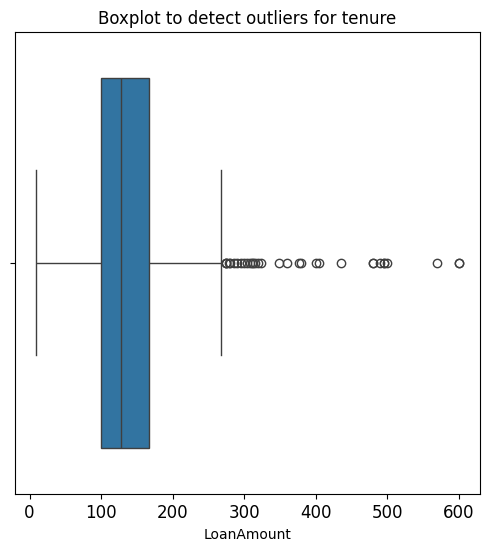

In [8]:
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=loan_data['LoanAmount'])
plt.show()

In [9]:
percentile25 = loan_data['LoanAmount'].quantile(0.25)

percentile75 = loan_data['LoanAmount'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

outliers = loan_data[(loan_data['LoanAmount'] > upper_limit) | (loan_data['LoanAmount'] < lower_limit)]

print("Number of rows in the data containing outliers in `LoanAmount`:", len(outliers))

Lower limit: -0.5
Upper limit: 267.5
Number of rows in the data containing outliers in `LoanAmount`: 32


## Data Preporcessing and Visualisation

## <h3> Getting count of columns with categorical data

In [10]:
obj = (loan_data.dtypes=='object')
catv = list(loan_data.columns[obj])
print(f'Categorical variables: {catv}')
print(f'Categorical Variables count: {len(list(obj[obj].index))}')

Categorical variables: ['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
Categorical Variables count: 7


## <h3> Loan_ID is completely unique and not correlated with any other attribute hence it is dropped

In [11]:
loan_data.drop(['Loan_ID'],axis=1,inplace=True)

## <h3> Visualising all categorical variables to identify the dominant value in the resective variable

In [12]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 1 to 597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             505 non-null    object 
 1   Married            505 non-null    object 
 2   Dependents         505 non-null    float64
 3   Education          505 non-null    object 
 4   Self_Employed      505 non-null    object 
 5   ApplicantIncome    505 non-null    int64  
 6   CoapplicantIncome  505 non-null    float64
 7   LoanAmount         505 non-null    float64
 8   Loan_Amount_Term   505 non-null    float64
 9   Credit_History     505 non-null    float64
 10  Property_Area      505 non-null    object 
 11  Loan_Status        505 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 51.3+ KB


In [13]:
loan_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


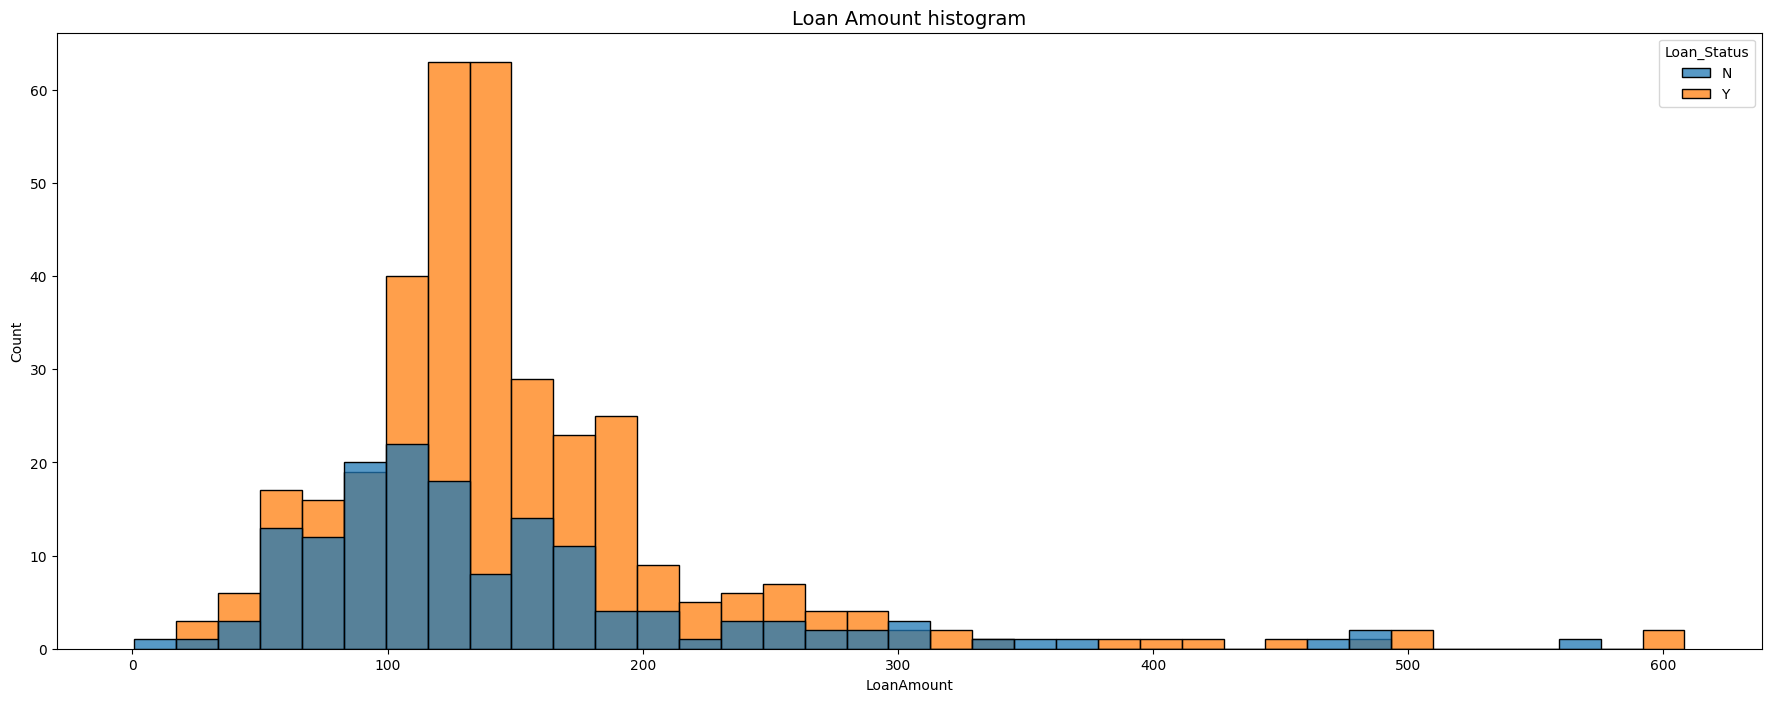

In [14]:
# Create a plot as needed 

# Set figure and axes
fig, ax = plt.subplots(1, figsize = (22,8))

# Create boxplot showing `applicant_income` distributions for `loan_amount`, comparing applicant's income to the amount of loan recieved
# sns.boxplot(data=loan_data, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', orient="h", ax=ax[0])
# sns.stripplot(data=loan_data, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', 
#               dodge=True, jitter=True, color='black', size=3, marker='o', alpha=0.5)
# ax[0].invert_yaxis()
# ax[0].set_title("Loan Amount by Applicant's Income", fontsize='14')

# Create histogram showing distribution of `loan_amount`, comparing the income of applicants
tenure_stay = loan_data[loan_data['Loan_Status']=='N']['ApplicantIncome']
tenure_left = loan_data[loan_data['Loan_Status']=='Y']['ApplicantIncome']
sns.histplot(data=loan_data, x='LoanAmount', hue='Loan_Status', multiple='dodge', shrink=2)
ax.set_title('Loan Amount histogram', fontsize='14')

# Display the plots
plt.show()

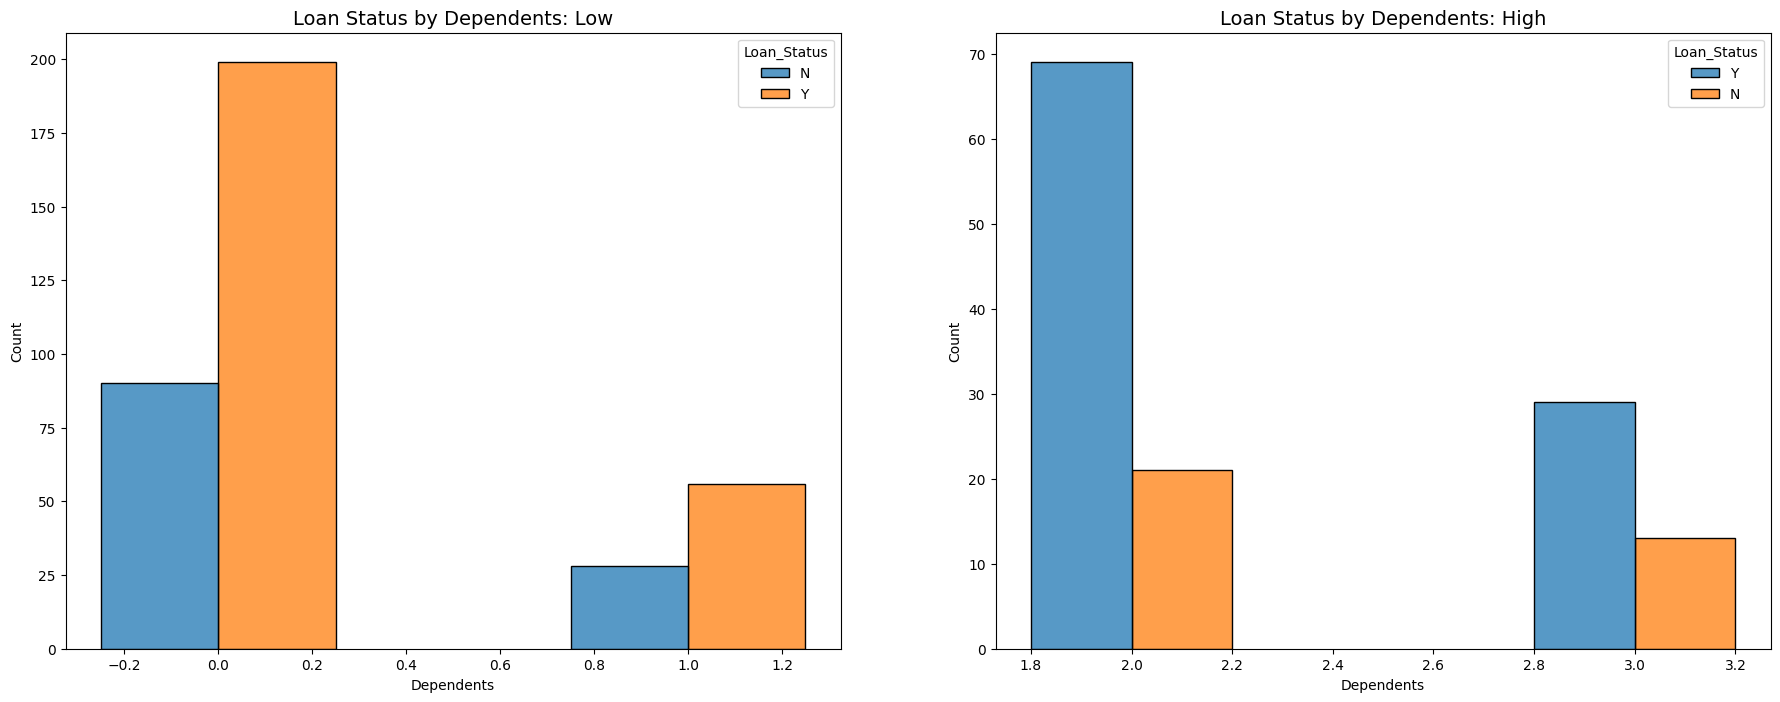

In [15]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize=(22, 8))

# Define low dependents
dependents_low = loan_data[loan_data['Dependents'] < 2]

# Define high dependents
dependents_high = loan_data[loan_data['Dependents'] >= 2]

# Plot low dependents histogram
sns.histplot(data=dependents_low, x='Dependents', hue='Loan_Status', discrete=True, 
             multiple='dodge', shrink=0.5, ax=ax[0])
ax[0].set_title('Loan Status by Dependents: Low', fontsize=14)

# Plot high dependents histogram
sns.histplot(data=dependents_high, x='Dependents', hue='Loan_Status', discrete=True, 
             multiple='dodge', shrink=0.4, ax=ax[1])
ax[1].set_title('Loan Status by Dependents: High', fontsize=14)

# Display the plots
plt.show()

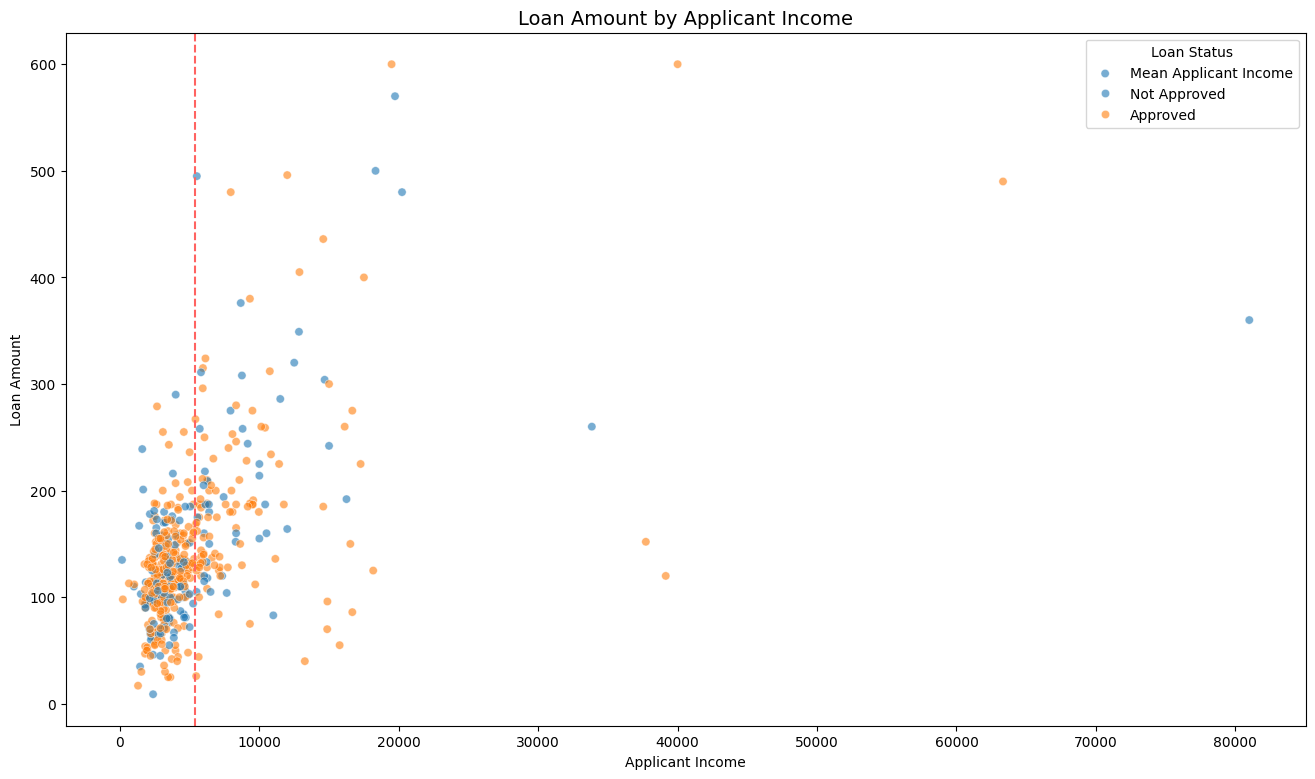

In [16]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=loan_data, x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', alpha=0.6)
plt.axvline(x=loan_data['ApplicantIncome'].mean(), color='#ff6361', label='Mean Applicant Income', ls='--')
plt.legend(title='Loan Status', labels=['Mean Applicant Income', 'Not Approved', 'Approved'])
plt.title('Loan Amount by Applicant Income', fontsize=14)
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.show()

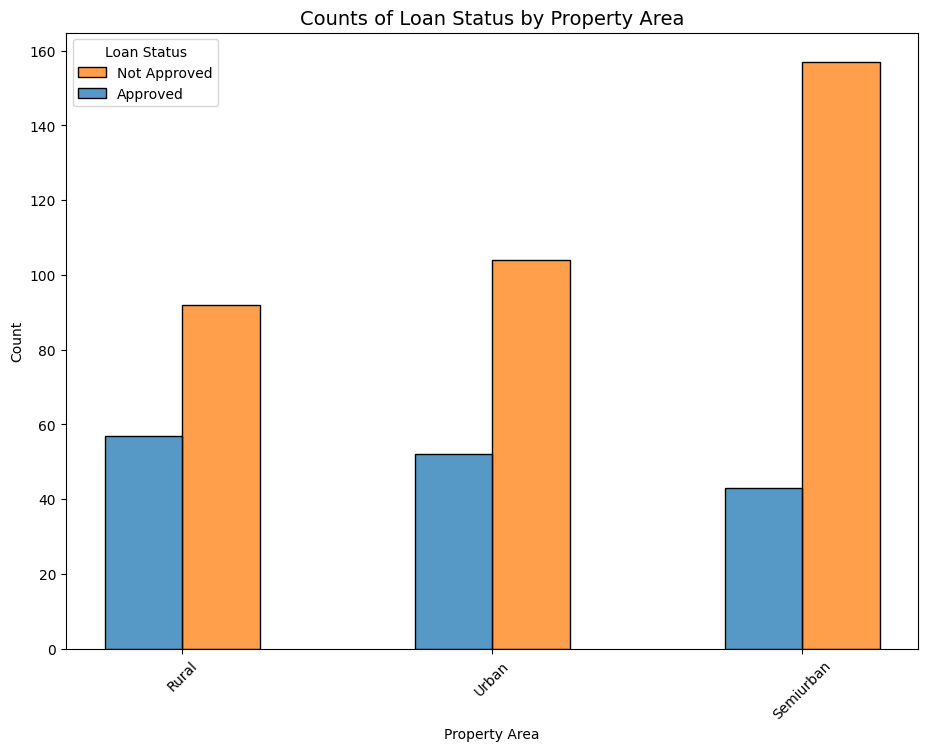

In [17]:
# Create stacked histogram to compare Property_Area distribution of loan status
plt.figure(figsize=(11, 8))
sns.histplot(data=loan_data, x='Property_Area', hue='Loan_Status', discrete=True, 
             hue_order=['N', 'Y'], multiple='dodge', shrink=0.5)
plt.xticks(rotation=45)
plt.title('Counts of Loan Status by Property Area', fontsize=14)
plt.xlabel('Property Area')
plt.ylabel('Count')
plt.legend(title='Loan Status', labels=['Not Approved', 'Approved'])
plt.show()

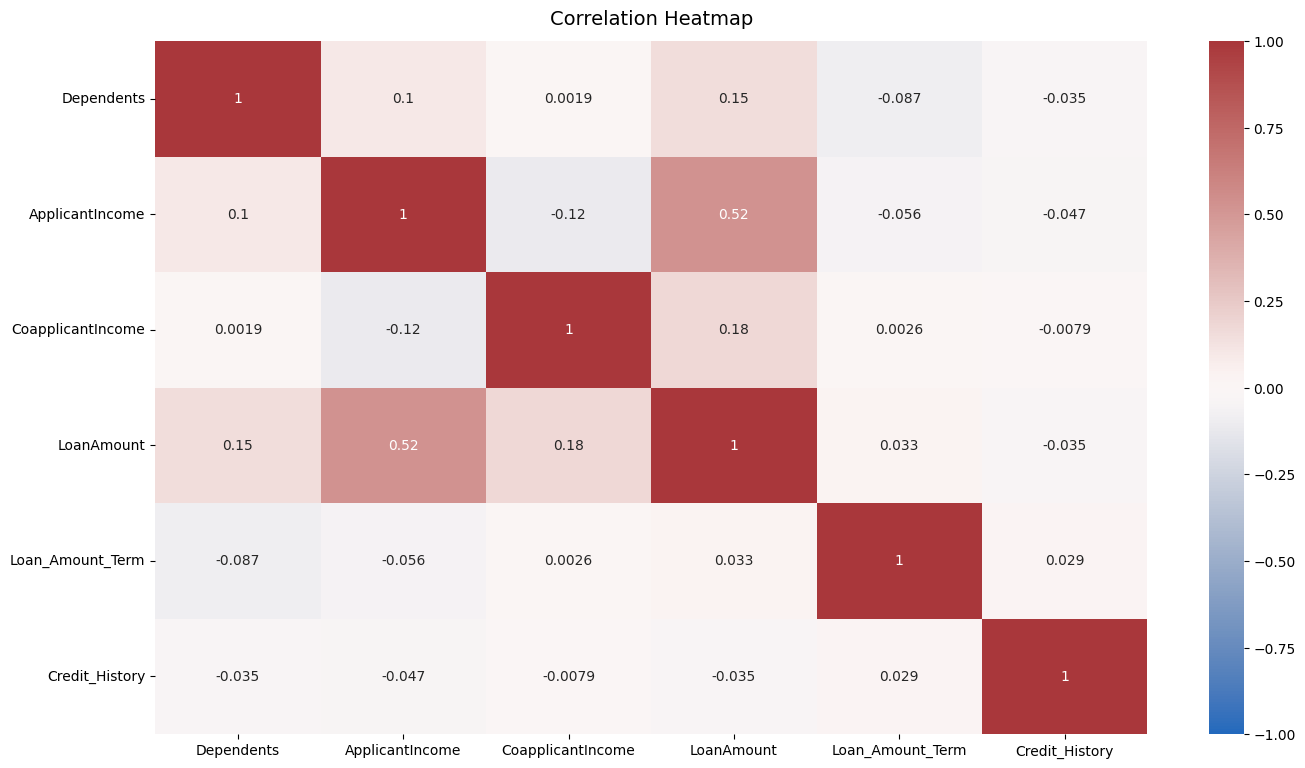

In [18]:
# Create a correlation heatmap
# Select only numerical columns for correlation
numerical_data = loan_data.select_dtypes(include=['float64', 'int64'])

# Create a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(numerical_data.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()

## Encoding variables

In [19]:
# Copy the dataframe
df_enc = loan_data.copy()

# Encode the `Education` column as an ordinal numeric category (Graduate: 1, Not Graduate: 0)
df_enc['Education'] = df_enc['Education'].astype('category').cat.set_categories(['Not Graduate', 'Graduate']).cat.codes

# Dummy encode the `Gender`, `Married`, `Self_Employed`, `Property_Area`, and `Loan_Status` columns
df_enc = pd.get_dummies(df_enc, columns=['Gender', 'Married', 'Self_Employed', 'Property_Area', 'Loan_Status'], drop_first=True)

# Display the new dataframe
df_enc.head()

,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
1,1.0,1,4583,1508.0,128.0,360.0,1.0,True,True,False,False,False,False
2,0.0,1,3000,0.0,66.0,360.0,1.0,True,True,True,False,True,True
3,0.0,0,2583,2358.0,120.0,360.0,1.0,True,True,False,False,True,True
4,0.0,1,6000,0.0,141.0,360.0,1.0,True,False,False,False,True,True
5,2.0,1,5417,4196.0,267.0,360.0,1.0,True,True,True,False,True,True


## Haetmap of Numerical variables

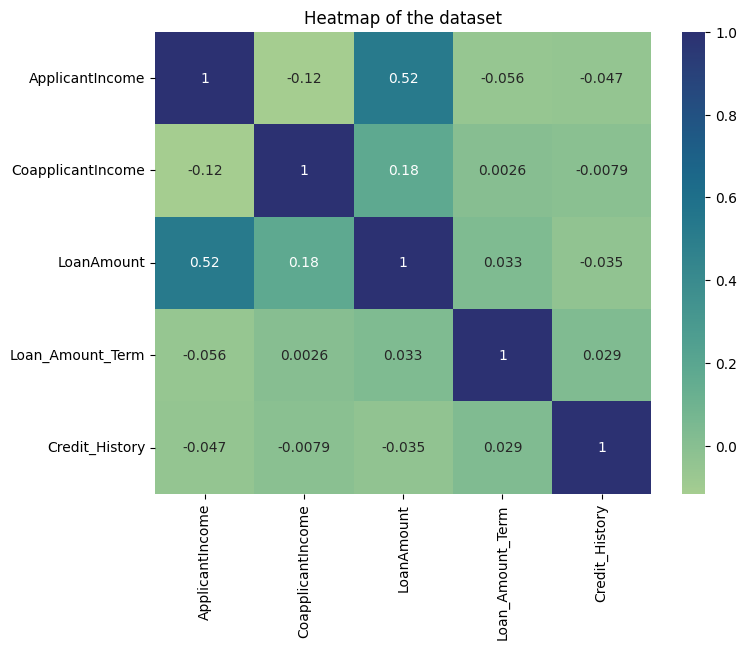

In [20]:
# Create a heatmap to visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(loan_data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [21]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 1 to 597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             505 non-null    object 
 1   Married            505 non-null    object 
 2   Dependents         505 non-null    float64
 3   Education          505 non-null    object 
 4   Self_Employed      505 non-null    object 
 5   ApplicantIncome    505 non-null    int64  
 6   CoapplicantIncome  505 non-null    float64
 7   LoanAmount         505 non-null    float64
 8   Loan_Amount_Term   505 non-null    float64
 9   Credit_History     505 non-null    float64
 10  Property_Area      505 non-null    object 
 11  Loan_Status        505 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 51.3+ KB


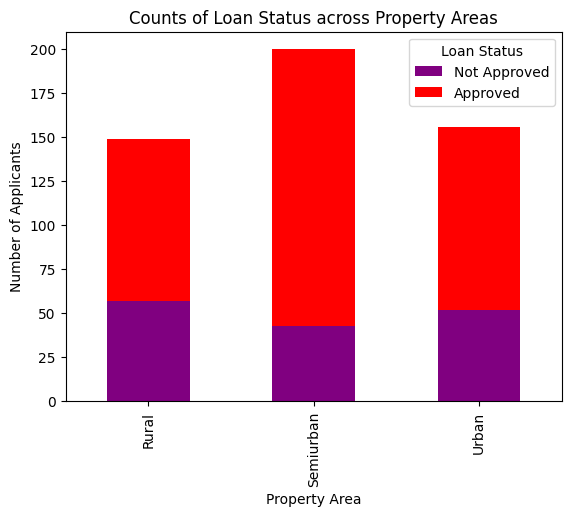

In [22]:
# Create a stacked bar plot
pd.crosstab(loan_data['Property_Area'], loan_data['Loan_Status']).plot(kind='bar', stacked=True, color=['purple', 'red'])
plt.title('Counts of Loan Status across Property Areas')
plt.xlabel('Property Area')
plt.ylabel('Number of Applicants')
plt.legend(title='Loan Status', labels=['Not Approved', 'Approved'])
plt.show()

## Encoding binary variable into integer values

In [23]:
# Convert 'Y' to 1 and 'N' to 0 in Loan_Status column
loan_data['Loan_Status'] = loan_data['Loan_Status'].replace({'Y': 1, 'N': 0})

# Display the modified DataFrame
loan_data.head()

C:\Users\Lovia E B\AppData\Local\Temp\ipykernel_13632\2796207151.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_data['Loan_Status'] = loan_data['Loan_Status'].replace({'Y': 1, 'N': 0})


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
5,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1


## Calculating Q1 and Q3 for Loan_amount

In [24]:
# Calculate the lower and upper limits for outliers using IQR method
Q1 = loan_data['LoanAmount'].quantile(0.25)
Q3 = loan_data['LoanAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Select rows without outliers in LoanAmount and save in a new variable
df_clean_loan = loan_data[(loan_data['LoanAmount'] >= lower_limit) & (loan_data['LoanAmount'] <= upper_limit)]

# Display first few rows of the new dataframe
df_clean_loan.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
5,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1


In [25]:
# Isolate the outcome variable
y = df_clean_loan['Loan_Status']

# Display first few rows of the outcome variable
y.head() 


1    0
2    1
3    1
4    1
5    1
Name: Loan_Status, dtype: int64

## Selecting features to be used in model

In [26]:
# Select the features you want to use in your model

selected_features = [
    'ApplicantIncome',
    'CoapplicantIncome',
    'LoanAmount',
    'Loan_Amount_Term',
    'Credit_History',
]

# Create a new DataFrame with selected features
df_features = df_clean_loan[selected_features + ['Loan_Status']]

# Display the first few rows of the new DataFrame
df_features.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
1,4583,1508.0,128.0,360.0,1.0,0
2,3000,0.0,66.0,360.0,1.0,1
3,2583,2358.0,120.0,360.0,1.0,1
4,6000,0.0,141.0,360.0,1.0,1
5,5417,4196.0,267.0,360.0,1.0,1


## Splitting dataset into training and testing sets

In [27]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target variable (y)
X = df_features.drop('Loan_Status', axis=1)
y = df_features['Loan_Status']

# Splitting into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Training Logistic Regression Model

In [28]:
from sklearn.linear_model import LogisticRegression

# Constructing the logistic regression model
logreg_model = LogisticRegression(random_state=42)

# Fitting the model to the training dataset
logreg_model.fit(X_train, y_train)

C:\Users\Lovia E B\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [29]:
# Making predictions on the test set
y_pred = logreg_model.predict(X_test)

## Confusion Matrix of Logistic regression Model

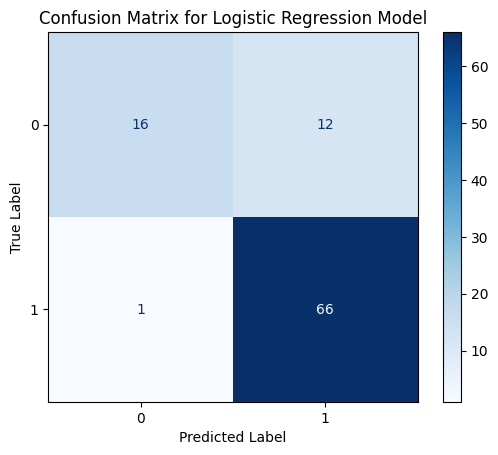

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [31]:
df_features['Loan_Status'].value_counts(normalize=True)

Loan_Status
1    0.708245
0    0.291755
Name: proportion, dtype: float64

In [32]:
from sklearn.metrics import classification_report

# Generating the classification report
classification_rep = classification_report(y_test, y_pred)

# Displaying the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.57      0.71        28
           1       0.85      0.99      0.91        67

    accuracy                           0.86        95
   macro avg       0.89      0.78      0.81        95
weighted avg       0.87      0.86      0.85        95



## Decision Tree

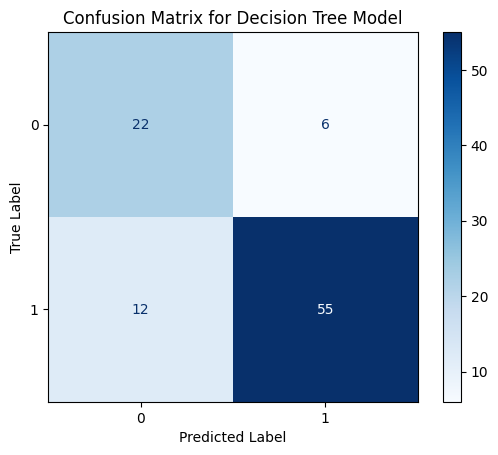

Decision Tree Model:
Accuracy: 0.8105263157894737
Confusion Matrix:
 [[22  6]
 [12 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.79      0.71        28
           1       0.90      0.82      0.86        67

    accuracy                           0.81        95
   macro avg       0.77      0.80      0.78        95
weighted avg       0.83      0.81      0.82        95



In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Data Preprocessing
# Assuming you have already preprocessed the data and have features (X) and target variable (y)

# 2. Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Decision Tree Model
# Create a Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
dt_y_pred = dt_model.predict(X_test)

# Evaluate the Decision Tree model
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_conf_matrix, display_labels=dt_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
dt_classification_rep = classification_report(y_test, dt_y_pred)

print("Decision Tree Model:")
print("Accuracy:", dt_accuracy)
print("Confusion Matrix:\n", dt_conf_matrix)
print("Classification Report:\n", dt_classification_rep)


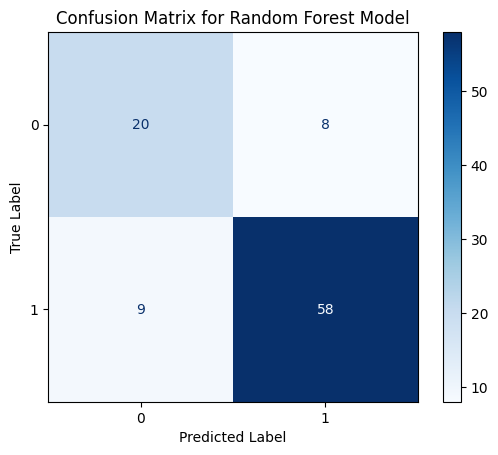


Random Forest Model:
Accuracy: 0.8210526315789474
Confusion Matrix:
 [[20  8]
 [ 9 58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70        28
           1       0.88      0.87      0.87        67

    accuracy                           0.82        95
   macro avg       0.78      0.79      0.79        95
weighted avg       0.82      0.82      0.82        95



In [34]:
# 4. Random Forest Model
# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
rf_y_pred = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
rf_classification_rep = classification_report(y_test, rf_y_pred)



print("\nRandom Forest Model:")
print("Accuracy:", rf_accuracy)
print("Confusion Matrix:\n", rf_conf_matrix)
print("Classification Report:\n", rf_classification_rep)


## <h3> Gender

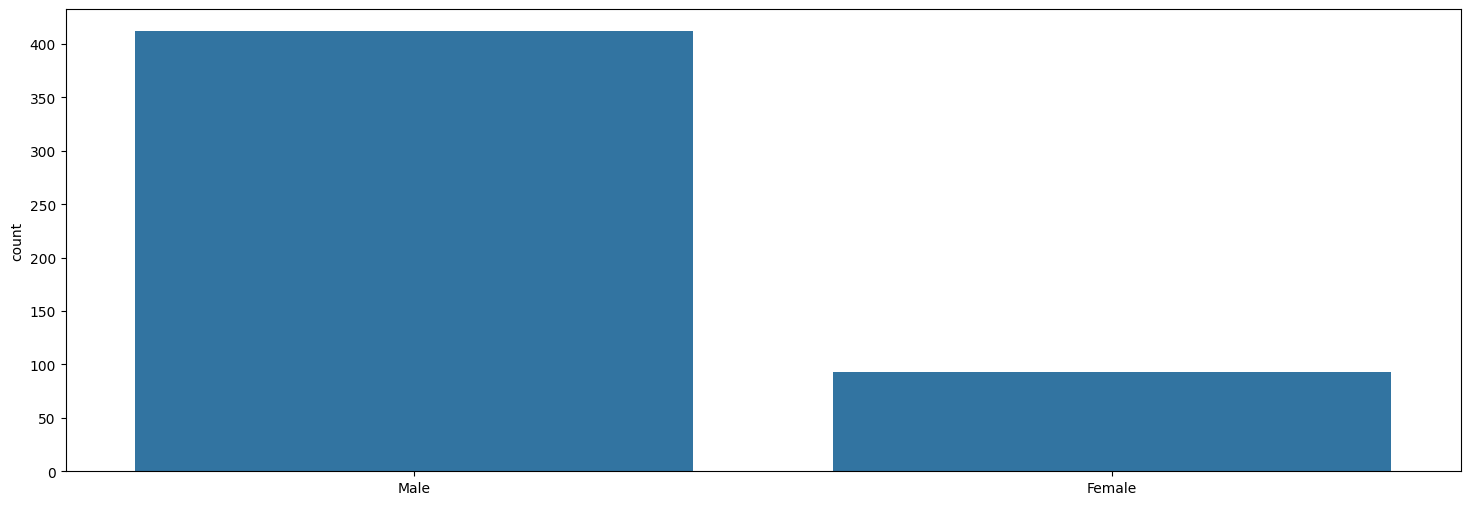

In [35]:
plt.figure(figsize=(18,6))
y=loan_data['Gender'].value_counts()
sns.barplot(x=list(y.index),y=y)
plt.show()

## <h3> Married

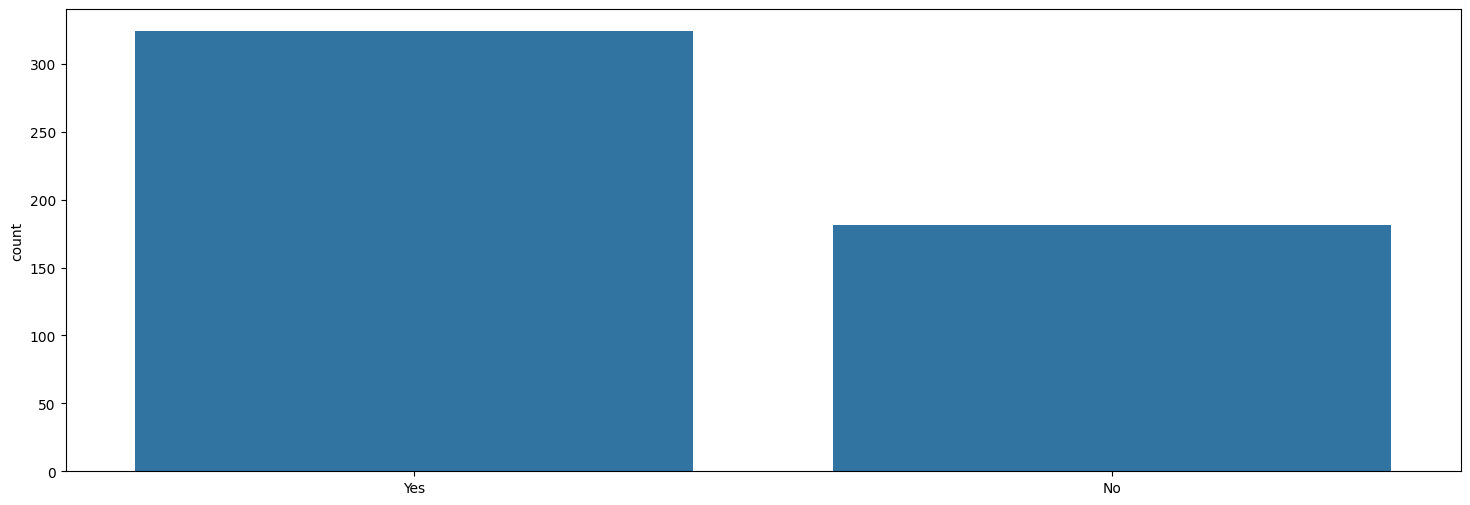

In [36]:
plt.figure(figsize=(18,6))
y=loan_data['Married'].value_counts()
sns.barplot(x=list(y.index),y=y)
plt.show()

## <h3> Education

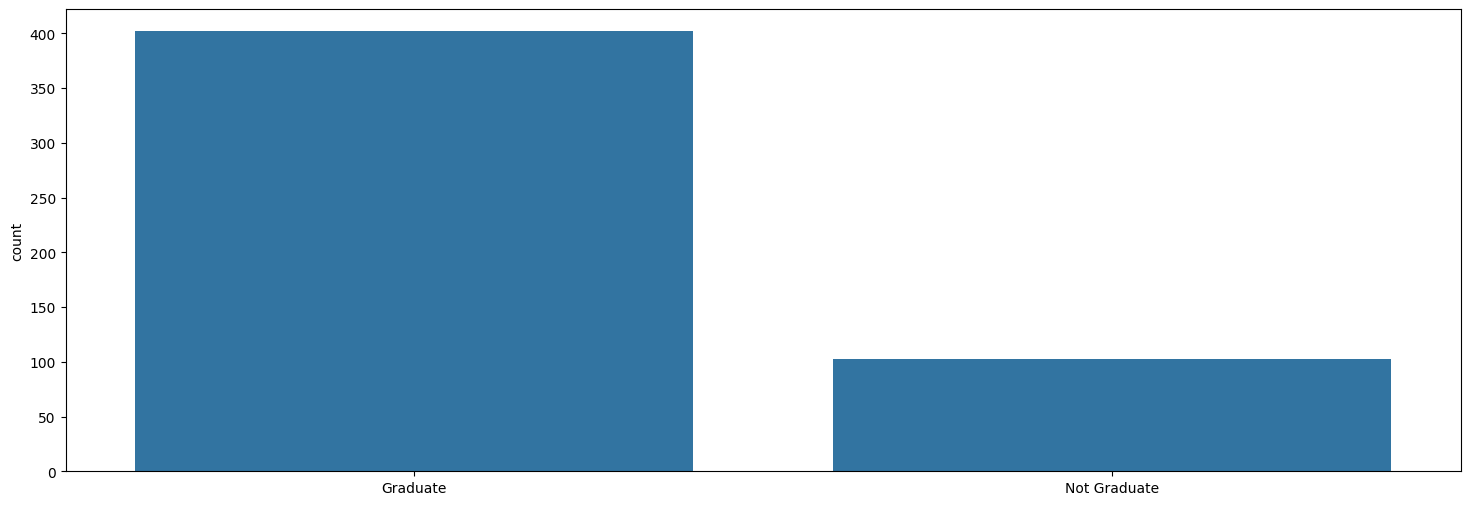

In [37]:
plt.figure(figsize=(18,6))
y=loan_data['Education'].value_counts()
sns.barplot(x=list(y.index),y=y)
plt.show()

## <h3> Self_Employed

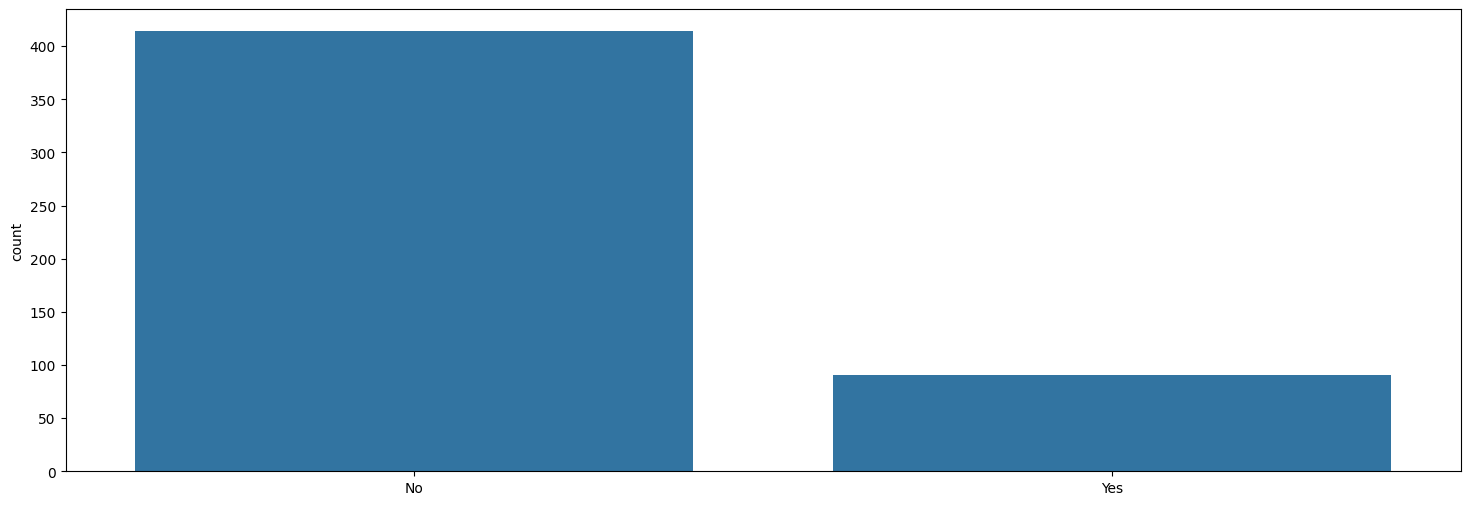

In [38]:
plt.figure(figsize=(18,6))
y=loan_data['Self_Employed'].value_counts()
sns.barplot(x=list(y.index),y=y)
plt.show()

## <h3> Property_Area

## <h3> Loan_Status

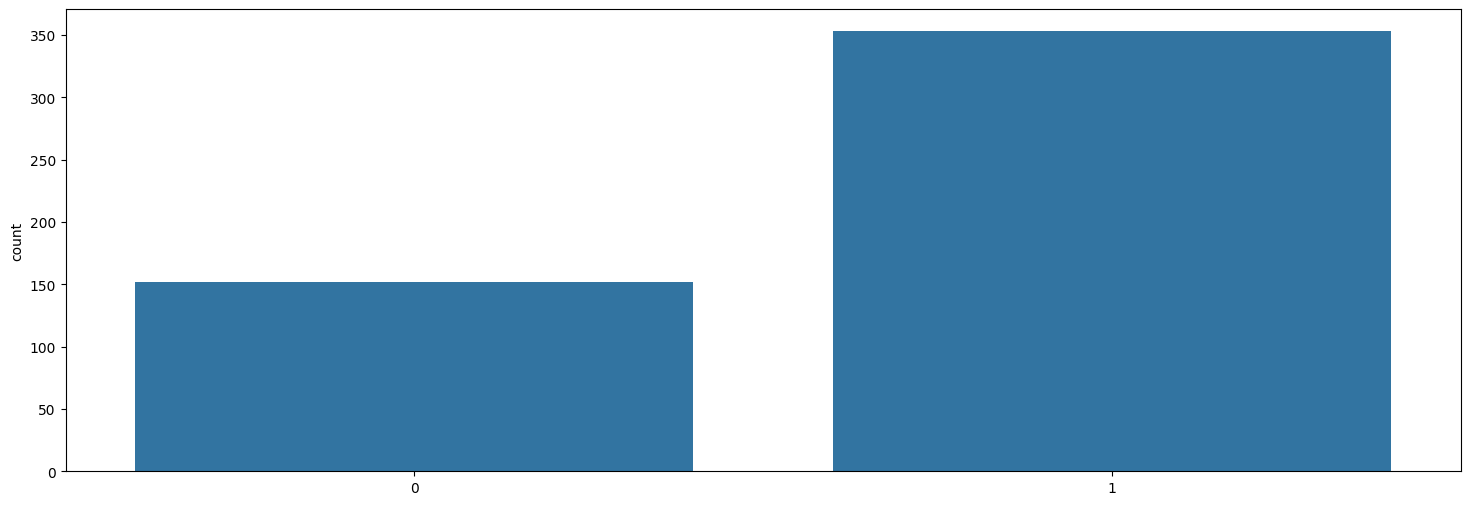

In [39]:
plt.figure(figsize=(18,6))
y=loan_data['Loan_Status'].value_counts()
sns.barplot(x=list(y.index),y=y)
plt.show()

## <h3> All categorical variables are binary so we use LabelEncoder for all coluns and change them into int datatype 

In [40]:
from sklearn import preprocessing
## Use label encoder to assgin ineger value to categorical variables
label_encoder = preprocessing.LabelEncoder()
obj = (loan_data.dtypes=='object')
for col in list(obj[obj].index):
    loan_data[col]=label_encoder.fit_transform(loan_data[col])

## <h3> Check if there are any columns left with datatype as object

In [41]:
obj = (loan_data.dtypes=='object')
print(f'Categorical variables: {len(list(obj[obj].index))}')

Categorical variables: 0


## <h3> Plotting heatmap to find correlated variables

<Axes: >

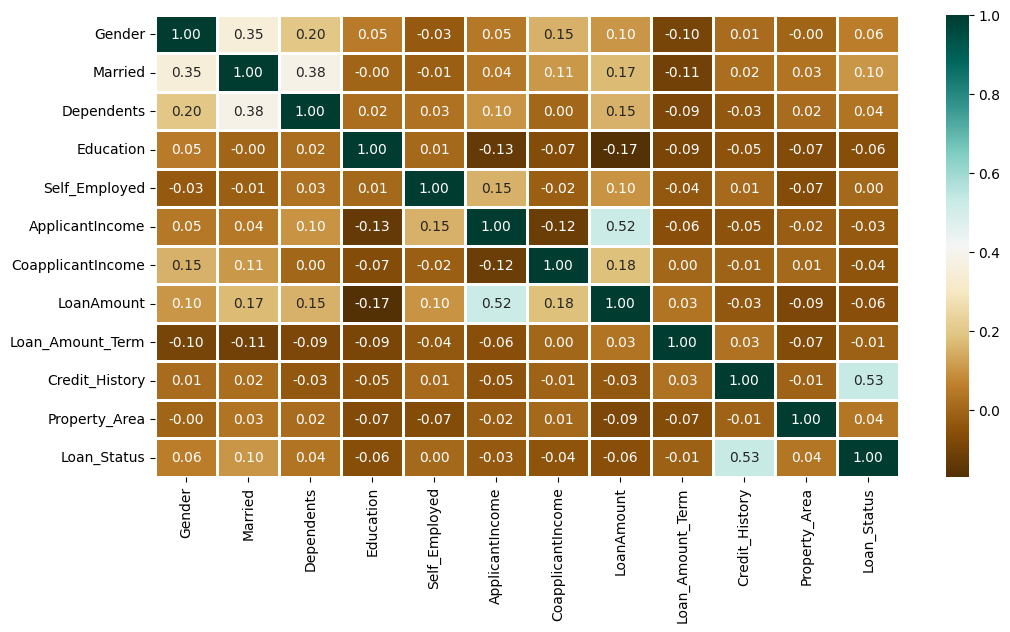

In [42]:
plt.figure(figsize=(12,6))
sns.heatmap(loan_data.corr(),cmap='BrBG',fmt='.2f',linewidths=2,annot=True)

## <h3> The above heatmap is showing correlation between LoanAmount and ApplicantIncome. It also shows Credit_History has high impact on Loan_Status

## <h3> Using Catplot to visualize relation between Gender and Marital status of Applicant

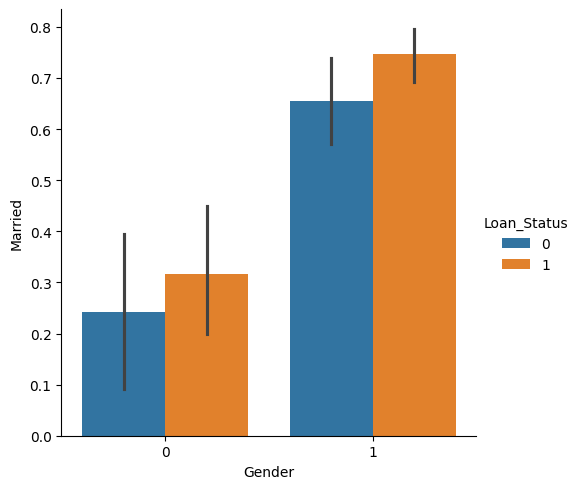

In [43]:
sns.catplot(x='Gender',y='Married',hue='Loan_Status',kind='bar',data=loan_data)

## <h3> Checking for missing and null values. If any missing or null values are present they are filled with the mean values of that attribute

In [44]:
for col in loan_data.columns:
    loan_data[col]=loan_data[col].fillna(loan_data[col].mean())
loan_data.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## <h3> Since there are no missing values present we proceed to model selection

## <h3> Splitting dataset

In [45]:
from sklearn.model_selection import train_test_split
X = loan_data.drop(['Loan_Status'],axis=1)
Y = loan_data['Loan_Status']
X.shape,Y.shape

((505, 11), (505,))

In [46]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=1)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((303, 11), (202, 11), (303,), (202,))

## Model Training and Evaluation with visualisation of model performance

## <h3> 1.KNeighborsClassifier

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train,Y_train)
knn_pred = knn_model.predict(X_train)
print(f'Accuracy of KNeighborsClassifier: {100*metrics.accuracy_score(Y_train,knn_pred)}')

Accuracy of KNeighborsClassifier: 79.53795379537954


## <h3> 2.Logistic Regression

## <h3> 3.Support Vector Classifier(SVC)

In [48]:
from sklearn.svm import SVC
from sklearn import metrics

svc_model = SVC()
svc_model.fit(X_train,Y_train)
svc_pred = svc_model.predict(X_train)
print(f'Accuracy of SVC: {100*metrics.accuracy_score(Y_train,svc_pred)}')

Accuracy of SVC: 73.26732673267327


## <h3> 4.RandomForestClassifier

## Visualisation of model performance

## <h3> 1.KNeighborsClassifier

## <h3> Confusion Matrix

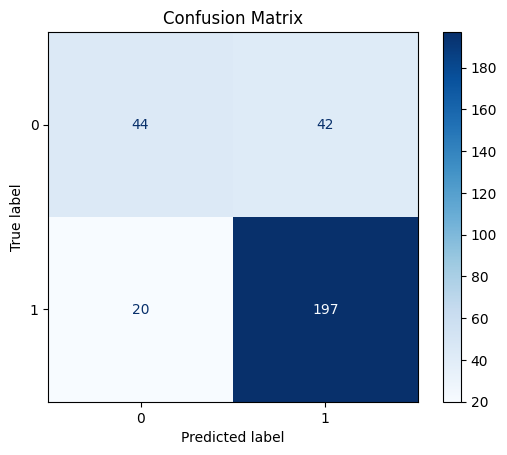

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting on the training data
knn_pred = knn_model.predict(X_train)

# Confusion Matrix
cm = confusion_matrix(Y_train, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## <h3> Confusion Matrix

## <h3> 3.SupportvectorClassifier

## <h3> Confusion Matrix

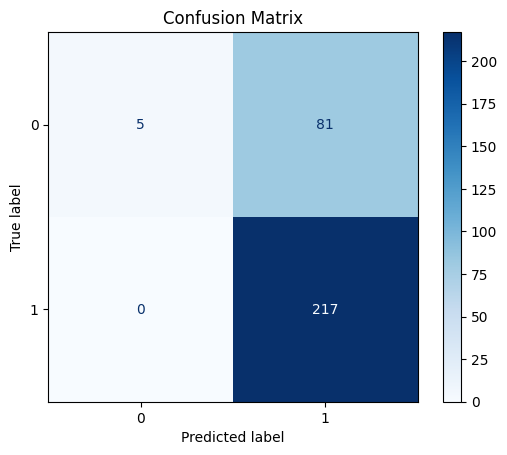

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Confusion Matrix
cm = confusion_matrix(Y_train,svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [53]:
loan_data.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,1,1,1.0,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0.0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0.0,1,0,2583,2358.0,120.0,360.0,1.0,2,1


In [54]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 1 to 597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             505 non-null    int32  
 1   Married            505 non-null    int32  
 2   Dependents         505 non-null    float64
 3   Education          505 non-null    int32  
 4   Self_Employed      505 non-null    int32  
 5   ApplicantIncome    505 non-null    int64  
 6   CoapplicantIncome  505 non-null    float64
 7   LoanAmount         505 non-null    float64
 8   Loan_Amount_Term   505 non-null    float64
 9   Credit_History     505 non-null    float64
 10  Property_Area      505 non-null    int32  
 11  Loan_Status        505 non-null    int64  
dtypes: float64(5), int32(5), int64(2)
memory usage: 41.4 KB


L1 Regularization Coefficients:
Gender               0.112559
Married              0.270044
Dependents           0.055488
Education           -0.098424
Self_Employed        0.061565
ApplicantIncome      0.109292
CoapplicantIncome   -0.118034
LoanAmount          -0.236355
Loan_Amount_Term    -0.044551
Credit_History       1.110046
Property_Area        0.000000
dtype: float64
Intercept: [0.81759885]
L2 Regularization Coefficients:
Gender               0.126522
Married              0.278441
Dependents           0.068534
Education           -0.116490
Self_Employed        0.075888
ApplicantIncome      0.141261
CoapplicantIncome   -0.126432
LoanAmount          -0.271374
Loan_Amount_Term    -0.055772
Credit_History       1.108649
Property_Area        0.008516
dtype: float64
Intercept: [0.8401569]


C:\Users\Lovia E B\AppData\Local\Temp\ipykernel_13632\3568806966.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


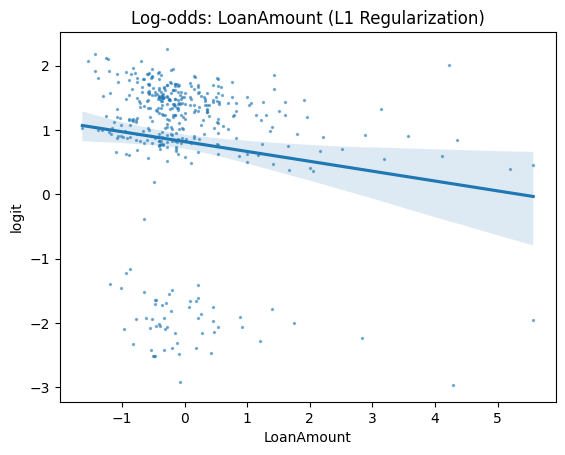

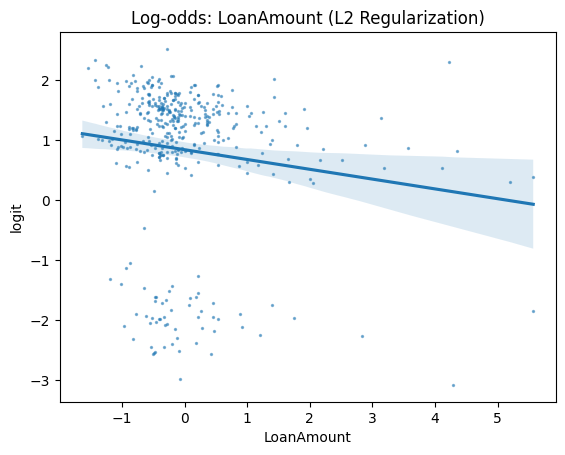

L1 Regularization Model Score: 0.8910891089108911


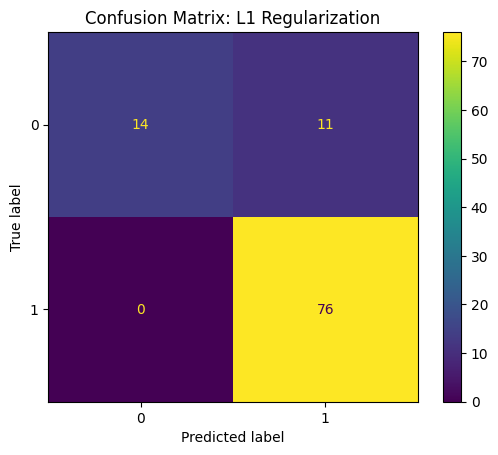

L2 Regularization Model Score: 0.8910891089108911


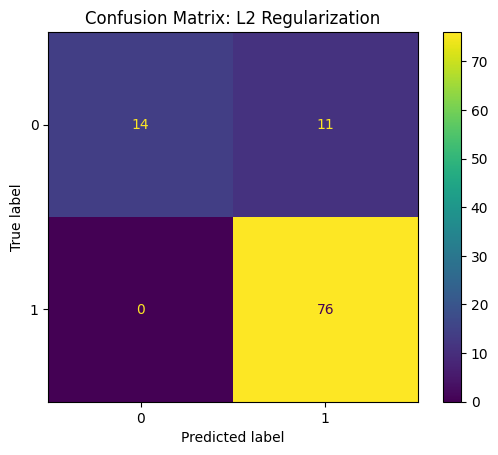

L1 Regularization Classification Report
              precision    recall  f1-score   support

           0       1.00      0.56      0.72        25
           1       0.87      1.00      0.93        76

    accuracy                           0.89       101
   macro avg       0.94      0.78      0.83       101
weighted avg       0.90      0.89      0.88       101

L2 Regularization Classification Report
              precision    recall  f1-score   support

           0       1.00      0.56      0.72        25
           1       0.87      1.00      0.93        76

    accuracy                           0.89       101
   macro avg       0.94      0.78      0.83       101
weighted avg       0.90      0.89      0.88       101



In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load your data
data = loan_data # Adjust the filename as needed

# Data Preprocessing
# Handle missing values
data.fillna(method='ffill', inplace=True)

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Loan_ID':
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

# Separate features and target variable
X = data.drop(['Loan_Status'], axis=1)
y = data['Loan_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression with L1 Regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=400)
model_l1.fit(X_train, y_train)

# Logistic Regression with L2 Regularization
model_l2 = LogisticRegression(penalty='l2', max_iter=400)
model_l2.fit(X_train, y_train)

# Model Coefficients
print("L1 Regularization Coefficients:")
print(pd.Series(model_l1.coef_[0], index=X.columns))
print("Intercept:", model_l1.intercept_)

print("L2 Regularization Coefficients:")
print(pd.Series(model_l2.coef_[0], index=X.columns))
print("Intercept:", model_l2.intercept_)

# Training Probabilities
training_probabilities_l1 = model_l1.predict_proba(X_train)
training_probabilities_l2 = model_l2.predict_proba(X_train)

# Create a new 'logit' column in the `logit_data` dataframe for L1
logit_data_l1 = pd.DataFrame(X_train, columns=X.columns)
logit_data_l1['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities_l1]

# Create a new 'logit' column in the `logit_data` dataframe for L2
logit_data_l2 = pd.DataFrame(X_train, columns=X.columns)
logit_data_l2['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities_l2]

# Plot regplot of `LoanAmount` log-odds for L1
sns.regplot(x='LoanAmount', y='logit', data=logit_data_l1, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: LoanAmount (L1 Regularization)')
plt.show()

# Plot regplot of `LoanAmount` log-odds for L2
sns.regplot(x='LoanAmount', y='logit', data=logit_data_l2, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: LoanAmount (L2 Regularization)')
plt.show()

# Model Evaluation for L1
y_preds_l1 = model_l1.predict(X_test)
print("L1 Regularization Model Score:", model_l1.score(X_test, y_test))
cm_l1 = confusion_matrix(y_test, y_preds_l1)
disp_l1 = ConfusionMatrixDisplay(confusion_matrix=cm_l1, display_labels=np.unique(y))
disp_l1.plot()
plt.title('Confusion Matrix: L1 Regularization')
plt.show()

# Model Evaluation for L2
y_preds_l2 = model_l2.predict(X_test)
print("L2 Regularization Model Score:", model_l2.score(X_test, y_test))
cm_l2 = confusion_matrix(y_test, y_preds_l2)
disp_l2 = ConfusionMatrixDisplay(confusion_matrix=cm_l2, display_labels=np.unique(y))
disp_l2.plot()
plt.title('Confusion Matrix: L2 Regularization')
plt.show()

# Print classification reports
print("L1 Regularization Classification Report")
print(classification_report(y_test, y_preds_l1))

print("L2 Regularization Classification Report")
print(classification_report(y_test, y_preds_l2))